In [0]:
!pip install -U -q PyDrive 

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1g9HXHixoWrFSMbPDGZy-GHp_31Xu-6Lr'})
downloaded.GetContentFile('attention.py')

In [0]:
downloaded = drive.CreateFile({'id':'1bMDcIwNq19WieDO9D7VOhRCPR7HTCuly'})
downloaded.GetContentFile('Reviews.csv')

In [0]:
downloaded = drive.CreateFile({'id':'1n__3DBl0VfkE679WUjrCujLJZcP2qH49'})
downloaded.GetContentFile('review_dataset.pkl')

In [0]:
downloaded = drive.CreateFile({'id':'1r1JjNCqC5MaKmFRVIPkM7v-2bkLzKWq6'})
downloaded.GetContentFile('review_dataset_.pkl')

In [0]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
from pickle import dump, load
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
max_text_len=30
max_summary_len=8

In [0]:
stories = load(open('review_dataset_.pkl', 'rb'))
print(len(stories))

99994


In [0]:
short_text = []
short_summary = []
for i in range(len(stories)):
    if(len(stories[i]['highlights'].split())<=max_summary_len and len(stories[i]['story'].split())<=max_text_len):
        short_text.append(stories[i]['story'])
        short_summary.append(stories[i]['highlights'])

In [0]:
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(np.array(df['text']), np.array(df['summary']), test_size=0.1, random_state=0, shuffle=True) 

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [0]:
x_tokenizer.word_counts.items()

odict_items([('cheese', 710), ('pack', 1019), ('popcorn', 1004), ('mostly', 144), ('salt', 1532), ('put', 975), ('salty', 659), ('orange', 275), ('taste', 8039), ('anything', 825), ('like', 10289), ('without', 1401), ('packet', 164), ('bland', 220), ('dull', 20), ('looks', 315), ('best', 4812), ('skip', 33), ('look', 558), ('something', 1082), ('better', 3201), ('coffee', 6834), ('great', 11962), ('price', 4427), ('even', 2386), ('greater', 20), ('try', 2513), ('shall', 388), ('surprised', 361), ('quality', 1539), ('made', 1767), ('sugar', 1817), ('free', 1946), ('hot', 1589), ('chocolate', 2504), ('tonight', 17), ('using', 1016), ('drops', 83), ('boy', 74), ('make', 2691), ('huge', 283), ('difference', 304), ('compared', 310), ('regular', 1172), ('stevia', 172), ('vanilla', 599), ('perfect', 1931), ('cocoa', 400), ('dog', 2917), ('loves', 2772), ('treats', 1712), ('started', 335), ('training', 289), ('purposes', 29), ('healthy', 1607), ('fed', 51), ('happy', 1449), ('hip', 29), ('dogs

In [0]:
thresh=4
cnt=0
tot_cnt=0
for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    if(value<thresh):
        cnt=cnt+1
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)

% of rare words in vocabulary: 62.42035528925272


In [0]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_voc   =  x_tokenizer.num_words + 1

In [0]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [0]:
thresh=6
cnt=0
tot_cnt=0
for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    if(value<thresh):
        cnt=cnt+1

In [0]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_voc  =   y_tokenizer.num_words +1

In [0]:
y_tokenizer.word_counts['sostok'],len(y_tr)  

(45944, 45944)

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [0]:
from tensorflow.keras import backend as K 
# K.clear_session()
latent_dim = 300
embedding_dim=100
encoder_inputs = Input(shape=(max_text_len,))
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      890700      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
350/350 [==============================] - 144s 412ms/step - loss: 2.8764 - val_loss: 2.6399
Epoch 2/10
350/350 [==============================] - 145s 414ms/step - loss: 2.5496 - val_loss: 2.4773
Epoch 3/10
350/350 [==============================] - 145s 413ms/step - loss: 2.3596 - val_loss: 2.2911
Epoch 4/10
350/350 [==============================] - 142s 406ms/step - loss: 2.2428 - val_loss: 2.2194
Epoch 5/10
350/350 [==============================] - 141s 402ms/step - loss: 2.1616 - val_loss: 2.1679
Epoch 6/10
350/350 [==============================] - 140s 400ms/step - loss: 2.0970 - val_loss: 2.1274
Epoch 7/10
350/350 [==============================] - 142s 404ms/step - loss: 2.0419 - val_loss: 2.0961
Epoch 8/10
350/350 [==============================] - 142s 405ms/step - loss: 1.9915 - val_loss: 2.0721
Epoch 9/10
350/350 [==============================] - 141s 403ms/step - loss: 1.9467 - val_loss: 2.0514
Epoch 10/10
350/350 [==============================] - 140s 400m

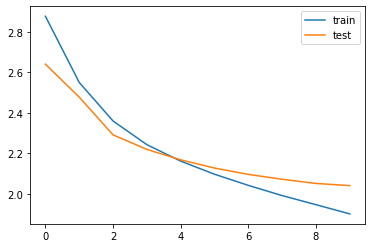

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
print("Review:",seq2text(x_tr[0]))
print("Original summary:",seq2summary(y_tr[0]))
print("Predicted summary:",decode_sequence(x_tr[0].reshape(1,max_text_len)))

Review: cheese pack popcorn mostly salt put popcorn salty popcorn orange taste anything like cheese without packet bland dull looks like popcorn best skip look something better 
Original summary: try for something better 
Predicted summary:  not popcorn


In [0]:
contractions = {"ain't": "am not",
                "aren't": "are not / am not",
                "can't": "cannot",
                "can't've": "cannot have",
                "'cause": "because",
                "could've": "could have",
                "couldn't": "could not",
                "couldn't've": "could not have",
                "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not",
                "hadn't": "had not",
                "hadn't've": "had not have",
                "hasn't": "has not",
                "haven't": "have not",
                "he'd": "he had / he would",
                "he'd've": "he would have",
                "he'll": "he shall / he will",
                "he'll've": "he shall have / he will have",
                "he's": "he has / he is",
                "how'd": "how did",
                "how'd'y": "how do you",
                "how'll": "how will",
                "how's": "how has / how is / how does",
                "I'd": "I had / I would",
                "I'd've": "I would have",
                "I'll": "I shall / I will",
                "I'll've": "I shall have / I will have",
                "I'm": "I am",
                "I've": "I have",
                "isn't": "is not",
                "it'd": "it had / it would",
                "it'd've": "it would have",
                "it'll": "it shall / it will",
                "it'll've": "it shall have / it will have",
                "it's": "it has / it is",
                "let's": "let us",
                "ma'am": "madam",
                "mayn't": "may not",
                "might've": "might have",
                "mightn't": "might not",
                "mightn't've": "might not have",
                "must've": "must have",
                "mustn't": "must not",
                "mustn't've": "must not have",
                "needn't": "need not",
                "needn't've": "need not have",
                "o'clock": "of the clock",
                "oughtn't": "ought not",
                "oughtn't've": "ought not have",
                "shan't": "shall not",
                "sha'n't": "shall not",
                "shan't've": "shall not have",
                "she'd": "she had / she would",
                "she'd've": "she would have",
                "she'll": "she shall / she will",
                "she'll've": "she shall have / she will have",
                "she's": "she has / she is",
                "should've": "should have",
                "shouldn't": "should not",
                "shouldn't've": "should not have",
                "so've": "so have",
                "so's": "so as / so is",
                "that'd": "that would / that had",
                "that'd've": "that would have",
                "that's": "that has / that is",
                "there'd": "there had / there would",
                "there'd've": "there would have",
                "there's": "there has / there is",
                "they'd": "they had / they would",
                "they'd've": "they would have",
                "they'll": "they shall / they will",
                "they'll've": "they shall have / they will have",
                "they're": "they are",
                "they've": "they have",
                "to've": "to have",
                "wasn't": "was not",
                "we'd": "we had / we would",
                "we'd've": "we would have",
                "we'll": "we will",
                "we'll've": "we will have",
                "we're": "we are",
                "we've": "we have",
                "weren't": "were not",
                "what'll": "what shall / what will",
                "what'll've": "what shall have / what will have",
                "what're": "what are",
                "what's": "what has / what is",
                "what've": "what have",
                "when's": "when has / when is",
                "when've": "when have",
                "where'd": "where did",
                "where's": "where has / where is",
                "where've": "where have",
                "who'll": "who shall / who will",
                "who'll've": "who shall have / who will have",
                "who's": "who has / who is",
                "who've": "who have",
                "why's": "why has / why is",
                "why've": "why have",
                "will've": "will have",
                "won't": "will not",
                "won't've": "will not have",
                "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have",
                "y'all": "you all",
                "y'all'd": "you all would",
                "y'all'd've": "you all would have",
                "y'all're": "you all are",
                "y'all've": "you all have",
                "you'd": "you had / you would",
                "you'd've": "you would have",
                "you'll": "you shall / you will",
                "you'll've": "you shall have / you will have",
                "you're": "you are",
                "you've": "you have"
                }

In [0]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text)
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

In [0]:
def text2seq(input_text):
    input_text = clean_text(input_text)
    input_text = np.array([input_text])
    str_tokenizer = Tokenizer(8906) 
    str_tokenizer.fit_on_texts(list(input_text))
    str_seq =   x_tokenizer.texts_to_sequences(input_text)
    str_seq =  pad_sequences(str_seq,  maxlen=max_text_len, padding='post')
    return str_seq

In [0]:
text_seq = text2seq("cheese pack popcorn mostly salt put popcorn salty popcorn orange taste anything like cheese without packet bland dull looks like popcorn best skip look something better")

In [0]:
print(decode_sequence(text_seq.reshape(1,max_text_len)))

 not popcorn
